<a href="https://colab.research.google.com/github/joansantoso/aimlsurabaya/blob/main/Multimodal_Gemma2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Install library
!pip install -U transformers
# !pip install accelerate
# Download Dataset
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip /content/Flickr8k_Dataset.zip
!unzip /content/Flickr8k_text.zip

!echo "Downloaded Flickr8k dataset successfully."
!mkdir saved_model
!mkdir uploaded

Streaming output truncated to the last 5000 lines.
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430526230_234b3550f6.jpg  
  inflating: Flicker8k_Dataset/3430607596_7e4f

In [5]:
import os
from transformers import AutoProcessor, CLIPVisionModel
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
from huggingface_hub import login
import urllib.request
from google.colab import userdata
HUGGINGFACE_TOKEN = userdata.get('HUGGINGFACE_TOKEN')
login(HUGGINGFACE_TOKEN)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Architecture

In [6]:
class MyAdaptor(nn.Module) :
  def __init__(self, vis_token_embedding_size, word_embedding_size) :
    super(MyAdaptor, self).__init__()
    self.vis_token_embedding_size = vis_token_embedding_size
    self.word_embedding_size = word_embedding_size

    self.adapter_linear = nn.Linear(self.vis_token_embedding_size, self.word_embedding_size)

  def forward(self, img_output) :
    self.adapter_linear.to(img_output.device)
    img_embed = self.adapter_linear(img_output)
    return img_embed

In [7]:
class MyModel(nn.Module) :
  def __init__(self) :
    super(MyModel, self).__init__()
    self.model_language = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it", torch_dtype=torch.bfloat16)
    self.tokenizer_language = AutoTokenizer.from_pretrained("google/gemma-2-2b-it", padding_side= 'right')
    self.image_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32").image_processor
    self.model_image = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")

    self.word_embedding_size = 2304
    self.num_vocab = 256000

    self.trigger_str_img = "<start_image>"
    self.num_vis_token_summary = 50
    self.vis_token_embedding_size = 768
    self.adaptor = MyAdaptor(self.vis_token_embedding_size,self.word_embedding_size )

    # add bias token on dummy prompt on first user instruction
    self.dummy_img_token = (" ".join(["the"]*self.num_vis_token_summary)).strip()

  def search_trigger_idx(self, text_token, trigger_str) :
    all_token = text_token
    all_string_now = ""
    all_token_now = []
    dummy_start_token = None
    for token_idx in range(len(all_token)) :
      token_now = int(all_token[token_idx].detach().cpu().numpy())
      all_token_now.append(token_now)
      token_as_string = self.tokenizer_language.batch_decode([all_token_now],skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

      if trigger_str in token_as_string :
        dummy_start_token = token_idx + 1
        break
    return dummy_start_token

  def get_image_embed(self, image_input) :
    img_output = self.model_image(image_input)['last_hidden_state']
    img_embed = self.adaptor(img_output)

    return img_embed


  def replace_embedding_hook(self, image_input) :
    image_feature = self.get_image_embed(image_input)
    assert len(image_feature) == 1

    def now_hook(model, input, output) :
      real_input = input[0]
      batch_size, token_len = real_input.shape
      if(token_len > 1) :
        assert batch_size == 1
        dummy_start_token = self.search_trigger_idx(real_input[0], self.trigger_str_img )

        temp = image_feature[0]
        output[:,dummy_start_token:dummy_start_token+self.num_vis_token_summary] = temp
      return output
    return now_hook



  def split_and_replace(self, now_input_tokens, replacement_embed, start_loc) :
    num_token = len(replacement_embed)

    start_embed = now_input_tokens[0:start_loc]
    end_embed = now_input_tokens[start_loc+num_token:]
    replaced_embed = torch.cat((start_embed, replacement_embed.to(now_input_tokens.dtype), end_embed),0)

    return replaced_embed

  def forward_loss(self, image_input_raw, caption_output_raw) :
    instruction_now =  "<start_of_turn>user\n"
    instruction_now += f"<start_image> {self.dummy_img_token}\n<end_image>\n"
    instruction_now += f"Create a simple description of the image!\n<end_of_turn>\n<start_of_turn>model\n"

    image_input = self.image_processor(image_input_raw, return_tensors="pt")['pixel_values']
    image_input = image_input.to(device)

    caption_output = self.tokenizer_language(caption_output_raw,padding=True,return_tensors="pt")
    caption_output['input_ids'] = caption_output['input_ids'].to(device)
    caption_output['attention_mask'] = caption_output['attention_mask'].to(device)

    img_output = self.model_image(image_input)['last_hidden_state']
    img_embed = self.adaptor(img_output)

    all_text_with_prompt = [instruction_now + temp_text for temp_text in self.tokenizer_language.batch_decode(caption_output['input_ids'], skip_special_tokens=True)]
    all_tokens_with_prompt = self.tokenizer_language(all_text_with_prompt, padding=True, return_tensors="pt")
    all_tokens_with_prompt['input_ids'] = all_tokens_with_prompt['input_ids'].to(device).detach()
    all_tokens_with_prompt['attention_mask'] = all_tokens_with_prompt['attention_mask'].to(device).detach()

    all_token_prompt_embed = self.model_language.model.embed_tokens(all_tokens_with_prompt['input_ids'])
    prompt_len = len(self.tokenizer_language([instruction_now])['input_ids'][0])
    caption_label_now = all_tokens_with_prompt['input_ids'][:,prompt_len:]
    caption_label_now = F.one_hot(caption_label_now,self.num_vocab)
    attn_mask_now = all_tokens_with_prompt['attention_mask'][:,prompt_len:]

    all_replaced_feature = []
    for temp_idx in range(len(all_tokens_with_prompt['input_ids'])) :
      tokens_text_now = all_tokens_with_prompt['input_ids'][temp_idx].detach().cpu()
      dummy_location_caption = self.search_trigger_idx(tokens_text_now, self.trigger_str_img )
      image_replaced_prompt = self.split_and_replace(all_token_prompt_embed[temp_idx], img_embed[temp_idx], dummy_location_caption)

      all_replaced_feature.append(image_replaced_prompt)
    all_replaced_feature = torch.stack(all_replaced_feature)


    logits_now = self.model_language(inputs_embeds =all_replaced_feature, attention_mask=all_tokens_with_prompt['attention_mask'])

    logits_now = logits_now['logits']
    caption_prediction_now = logits_now[:,prompt_len-1:-1]
    caption_prediction_now = torch.softmax(caption_prediction_now,-1)
    caption_prediction_now = torch.maximum(caption_prediction_now,torch.as_tensor(1e-10).to(caption_prediction_now.dtype))
    caption_prediction_now = torch.minimum(caption_prediction_now,torch.as_tensor(1 - 1e-10).to(caption_prediction_now.dtype))


    loss_lm = -torch.sum(caption_label_now*torch.log(caption_prediction_now),-1)
    loss_lm = torch.sum(loss_lm*attn_mask_now,-1)/torch.sum(attn_mask_now,-1)
    loss_lm = torch.mean(loss_lm)

    return loss_lm

  def generate_aswer_image(self, input_string, pil_image, max_new_tokens = 32, do_sample=True, top_k=50, top_p=0.95, temperature =1 ) :

    input_with_dummy_prompt = self.tokenizer_language.apply_chat_template(input_string, tokenize=False, add_generation_prompt=True)
    input_with_dummy_prompt = input_with_dummy_prompt.replace("<image>", "<start_image> "+self.dummy_img_token+"\n<end_image>")
    dummy_input = self.tokenizer_language(input_with_dummy_prompt,padding=True,return_tensors="pt")
    dummy_input['input_ids'] = dummy_input['input_ids'].to(device)
    dummy_input['attention_mask'] = dummy_input['attention_mask'].to(device)
    assert len(dummy_input['input_ids']) == 1

    handler_image = None

    contains_image = False
    if self.trigger_str_img in input_with_dummy_prompt :
      image_input = self.image_processor([pil_image], return_tensors="pt")['pixel_values'].to(device)
      hook_now_image = self.replace_embedding_hook(image_input)
      contains_image = True
      handler_image = self.model_language.model.embed_tokens.register_forward_hook(hook_now_image)



    output_now = self.model_language.generate(**dummy_input,
                                              max_new_tokens = max_new_tokens,
                                              do_sample=do_sample,
                                              temperature=temperature,
                                              top_k=top_k,
                                              top_p=top_p,
                                              )
    output_string = self.tokenizer_language.batch_decode(output_now, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

    if contains_image :
      handler_image.remove()

    return output_string.split("model\n")[-1]



# Hyperparameter

In [8]:
CAPTION_PATH = "/content/Flickr8k.token.txt"
IMAGES_FILE_PATH = "/content/Flicker8k_Dataset"
# SAVED_PATH = "/content/saved_model/adaptor_caption.pt"
SAVED_PATH = "/content/drive/MyDrive/Model/gemma/adaptor_caption2.pt"

BATCH_SIZE = 8
NUM_ITERATION = 2000
SAVE_EVERY = 200
LEARNING_RATE = 1e-4
TRAIN_DATA_NUM = 7500

device = 'cpu'
if torch.cuda.is_available() :
  device = 'cuda'

# Util Function

In [9]:
def check_model_nan(model) :
  num_nan = 0
  for param in model.parameters() :
    num_nan += torch.sum(torch.isnan(param))
  return num_nan > 0

In [12]:
def getLabelDictionary(file_path) :
  file_now = open(file_path)
  all_string = file_now.read()
  all_string = all_string.split('\n')
  label_dictionary = {}
  for line_now in all_string :
    splitted_line = line_now.split('\t')
    if len(splitted_line) > 1 :
      file_name_now = splitted_line[0].split('#')[0]
      number_now = splitted_line[0].split('#')[1]
      label_now = splitted_line[1]

      if file_name_now in label_dictionary.keys() :
        label_dictionary[file_name_now].append(label_now)
      else :
        label_dictionary.update({
            file_name_now:[label_now]
        })

  return label_dictionary

In [10]:
def count_model_param(model_now) :
  counter = 0
  for param in model_now.parameters() :
    counter = counter + torch.sum(torch.ones_like(param))
  return counter

In [11]:
def sample_data_caption(file_list_now, caption_dict_now, n) :
  # base_path = "/content/Flicker8k_Dataset"
  base_path = IMAGES_FILE_PATH
  rand_idx = np.random.randint(0,len(file_list_now), n)

  all_image = []
  all_text = []
  for idx_now in rand_idx :
    file_now = base_path + "/" + file_list_now[idx_now]
    image_now = Image.open(file_now)
    all_image.append(image_now)

    text_list_now = caption_dict_now[file_list_now[idx_now]]
    selected_text_now_idx = np.random.randint(0,len(text_list_now))
    all_text.append(text_list_now[selected_text_now_idx])

  return all_image, all_text

# Initialization

In [13]:
label_dictionary = getLabelDictionary(CAPTION_PATH)
all_file = os.listdir(IMAGES_FILE_PATH)

In [14]:
model = MyModel()
model = model.to(device)
model = model.to(torch.bfloat16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
# if load model
if os.path.exists(SAVED_PATH) :
  model.adaptor.load_state_dict(torch.load(SAVED_PATH))

<ipython-input-13-8bbbc381ed54>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.adaptor.load_state_dict(torch.load(SAVED_PATH))


In [15]:
for param in model.parameters() :
  param.requires_grad = True
for param in model.model_language.parameters() :
  param.requires_grad = False
for param in model.model_image.parameters() :
  param.requires_grad = False

In [16]:
optim = torch.optim.Adam(model.parameters(),LEARNING_RATE)

# Training

In [17]:
model.train()
for itr in range(NUM_ITERATION) :
  rand_image, rand_targets = sample_data_caption(all_file[0:TRAIN_DATA_NUM], label_dictionary, BATCH_SIZE)
  loss = model.forward_loss(rand_image, rand_targets)
  optim.zero_grad()
  loss.backward()
  optim.step()

  print((itr+1),"/", NUM_ITERATION,":", loss)

  if itr % SAVE_EVERY == (SAVE_EVERY - 1) :
    print("MODEL SAVED!")
    torch.save(model.adaptor.state_dict(),SAVED_PATH)


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


1 / 2000 : tensor(8.3245, device='cuda:0', grad_fn=<MeanBackward0>)
2 / 2000 : tensor(7.0877, device='cuda:0', grad_fn=<MeanBackward0>)
3 / 2000 : tensor(6.0058, device='cuda:0', grad_fn=<MeanBackward0>)
4 / 2000 : tensor(4.9207, device='cuda:0', grad_fn=<MeanBackward0>)
5 / 2000 : tensor(5.1023, device='cuda:0', grad_fn=<MeanBackward0>)
6 / 2000 : tensor(4.9727, device='cuda:0', grad_fn=<MeanBackward0>)
7 / 2000 : tensor(4.1440, device='cuda:0', grad_fn=<MeanBackward0>)
8 / 2000 : tensor(4.2922, device='cuda:0', grad_fn=<MeanBackward0>)
9 / 2000 : tensor(3.4311, device='cuda:0', grad_fn=<MeanBackward0>)
10 / 2000 : tensor(4.3351, device='cuda:0', grad_fn=<MeanBackward0>)
11 / 2000 : tensor(4.1932, device='cuda:0', grad_fn=<MeanBackward0>)
12 / 2000 : tensor(3.7733, device='cuda:0', grad_fn=<MeanBackward0>)
13 / 2000 : tensor(3.7406, device='cuda:0', grad_fn=<MeanBackward0>)
14 / 2000 : tensor(3.8823, device='cuda:0', grad_fn=<MeanBackward0>)
15 / 2000 : tensor(4.2816, device='cuda:0',

In [19]:
#manual save
torch.save(model.adaptor.state_dict(),SAVED_PATH)

# Inference

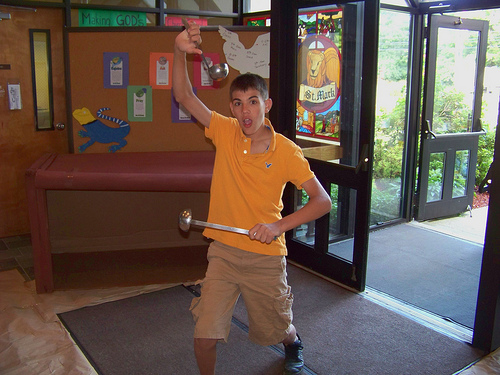

In [20]:
# random sample from unseen data in dataset
rand_image, rand_targets = sample_data_caption(all_file[TRAIN_DATA_NUM:], label_dictionary, 1)
rand_image = rand_image[0]
rand_targets = rand_targets[0]
rand_image

In [21]:
output_string = model.generate_aswer_image([{
    "role":"user",
    "content":"Create a short poem out of the <image>!"
}], rand_image)
print(output_string)

The 'max_batch_size' argument of HybridCache is deprecated and will be removed in v4.46. Use the more precisely named 'batch_size' argument instead.


A lonely boy stands . He swings and makes a sound . The swing was made for him to be alone . He stands in the shadow , and plays alone .


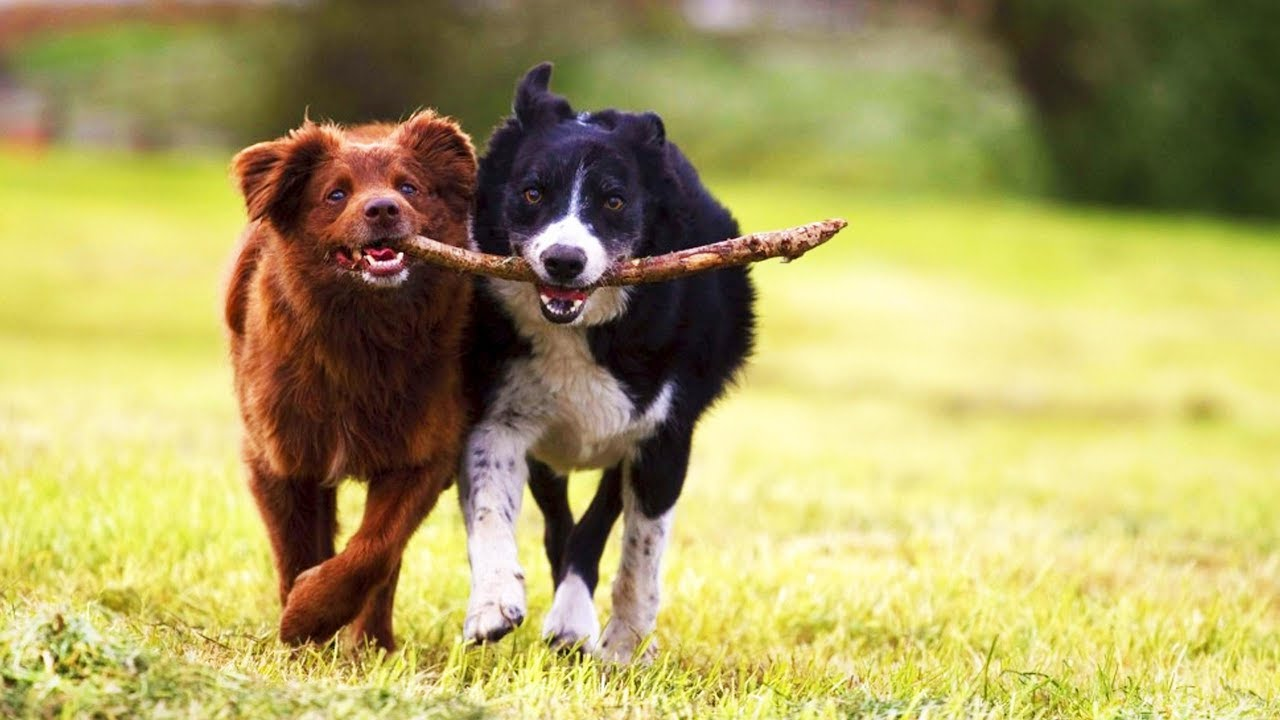

In [22]:
# use picture from the internet
image_url = "https://i.ytimg.com/vi/FHytoCvj90w/maxresdefault.jpg"
saved_name = "./temp_img." + image_url.split(".")[-1]
urllib.request.urlretrieve(image_url,saved_name)
pil_image_now = Image.open(saved_name)
pil_image_now

In [24]:
output_string = model.generate_aswer_image([{
    "role":"user",
    "content":"<image>Create a simple poem of the image!"
}], pil_image_now, max_new_tokens=256)
print(output_string)

A furry dog is in green grass .
He is holding a stick .
The big dog runs up to the fence .
But he cannot jump over it . 
</poem>



In [ ]:
# upload your own image
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

Saving cat-sleeping-on-the-patio.jpg to cat-sleeping-on-the-patio.jpg


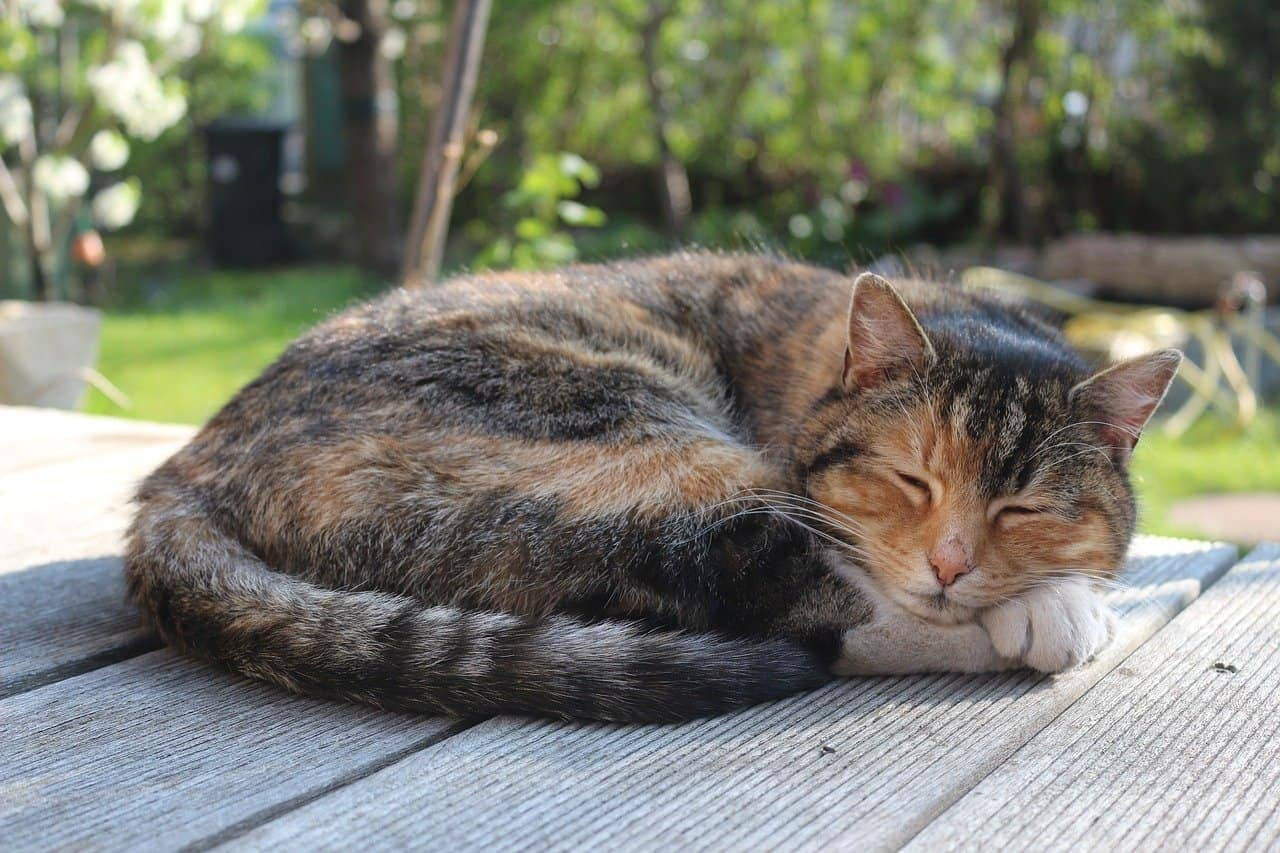

In [ ]:
temp = upload_files()
str_file_path = "/content/" + temp[0]
pil_image_now = Image.open(str_file_path)
pil_image_now

In [ ]:
output_string = model.generate_aswer_image([{
    "role":"user",
    "content":"<image>Create a simple description of the image!"
}], pil_image_now, max_new_tokens=256)
print(output_string)

A purple cat standing on its hind legs . it looks happy .
